# Step-by-step TDE resampling

First, import all packages as needed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
import lsst.sims.maf.utils as utils
from astropy.table import Table, Column
import json

Next, establish where the LSST simulations data is coming from, and where output data will go. This part should still use LSST's operations simulation database - the most recent is "minion1016" and is available here: https://www.lsst.org/scientists/simulations/opsim/opsim-survey-data.

In [2]:
runName = 'minion_1016'
opsdb = db.OpsimDatabase(runName + '_sqlite.db')
outDir = 'Observations Dictionary'
resultsDb = db.ResultsDb(outDir)

Using MAF, establish points of evaluation, how to evaluate (slice) them, and any constraints. We use the "pass" metric to simply retrieve data from the operations simulation without altering it at all, and we slice the data based on RA and Dec values at uniform intervals. The sql constraint can be a limitation on the number of nights observed a limitation on the filters of interest, a combination thereof, etc. Then, the metric, slicer, and constraint are run together as a "bundle." This bundle is then grouped with the previously setup opsim database (so the metrics know from where to retrieve data), the output directory, and the results database. Finally, the grouped bundle is ran to actually process all data.

In [3]:
metric = metrics.PassMetric(cols=['expMJD','filter','fiveSigmaDepth'])
slicer = slicers.UserPointsSlicer(np.random.uniform(0,360,size=10),np.random.uniform(-60,-30,size=10))
sql = ''

bundle = metricBundles.MetricBundle(metric,slicer,sql)

bg =  metricBundles.MetricBundleGroup({0:bundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
%time bg.runAll()

Querying database with no constraint.
Found 2447931 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
CPU times: user 30.9 s, sys: 1.46 s, total: 32.4 s
Wall time: 32.5 s


# Setting up & Testing functions

Now we want to set up a few functions that will be used to set up useful database tables, import outside data from a json file, and interpolate a lightcurve at the points of LSST's observations. While these could all be done on their own rather than set up as functions, this will make the final "for" loop overall much easier, since we want a robust system that can iterate over varying RA, Dec, peak magnitudes, and peak times.

This function simply tables a dictionary of the metric values we previously sliced and bundled, used by calling the "metricValues" from the bundle. In this case we have also "cleaned up" the table a bit: (1) subtracting the lowest "expMJD" value from each "expMJD" to have time listed in terms of day of observation, (2) sorting the data to be in order of observation time, and (3) ordering the table's columns. The next optional step is excluding the filters "u" and "y" because in the case of TDE PS1-10jh, there are not observations in those filters, so this data is unnecessary. This should be changed for a user with data in other filters as needed.

In [25]:
def Survey_Setup(bundle):
    opsimlist = []
    for coord in range(len(bundle.metricValues)):
        bdict = {key: bundle.metricValues[coord][key] for key in ['fieldRA', 'fieldDec', 
                                                                  'expMJD', 'filter', 'fiveSigmaDepth']}
        opsim = Table(bdict)
        opsim['expMJD'] = opsim['expMJD'] - opsim['expMJD'].min()
        opsim.sort(['expMJD'])
        opsim = opsim['fieldRA', 'fieldDec', 'expMJD','filter','fiveSigmaDepth']
    
        # Only do the following if you need to narrow simulation filters to those matching your lightcurve data
        opsim = opsim[opsim['filter'] != 'u']
        opsim = opsim[opsim['filter'] != 'y']
        opsimlist.append(opsim)
    return opsimlist

The above function can do without a "standardized" test, as it is straightforward and has even been used with different LSST operations simulations databases. Because it uses the metricValues from the bundle, testing this function would also require a test of the already-made and trusted bundling function. We will instead demonstrate how it works below.

In [26]:
opsimlist = Survey_Setup(bundle)
opsimlist

[<Table length=120>
 fieldRA  fieldDec      expMJD     filter fiveSigmaDepth
 float64  float64      float64     str256    float64    
 -------- -------- --------------- ------ --------------
 4.322605 -0.86838             0.0      i      23.042168
 4.322605 -0.86838 0.0107320000025      i       23.18391
 4.322605 -0.86838  0.951209999999      i      23.073645
 4.322605 -0.86838  0.965004999998      i      23.084745
 4.322605 -0.86838        0.965892      i      23.056753
 4.322605 -0.86838        1.027795      i      21.708536
 4.322605 -0.86838        1.954211      g      23.563324
 4.322605 -0.86838        1.961321      g      23.693831
 4.322605 -0.86838         1.96888      g      23.701138
 4.322605 -0.86838        1.977792      g      23.614703
      ...      ...             ...    ...            ...
 4.322605 -0.86838      170.843007      g      24.182419
 4.322605 -0.86838       170.85601      g      24.103202
 4.322605 -0.86838      173.706147      r      24.209112
 4.322605 -

Now that we have our operations simulations data selected and ordered, we want to start importing the lightcurve data of the TDE. Actual science procedures utilize the data for TDE PS1-10jh, which can be found here along with plenty of other data for potential TDEs: https://tde.space/. Note that all of these files are in the json format. We will be using a much smaller, made-up json file with arbitrary data in order to "test" the function.

In [6]:
def TDE_raw(jsonfile):
    # Open and load json file with TDE values
    tde_data = open(jsonfile)
    tde = json.load(tde_data)
    # Set up dictionary for json data
    data = {'mjd': [], 'filter': [], 'mag': [], 'magerror': [], 'upperlimit': []}
    # Use for loop to call to values within the json file
    for entry in tde['jsontest']['photometry']:
        # Ignore instances in which 'band' and 'magnitude' have no data
        if 'band' in entry and 'magnitude' in entry:
            data['mjd'].append(float(entry['time']))
            data['filter'].append(entry['band'])
            data['mag'].append(float(entry['magnitude']))
            # Ignore instances in which 'upperlimit' has no value (i.e. is 'false')
            if 'upperlimit' in entry:
                data['upperlimit'].append(entry['upperlimit'])
            else:
                data['upperlimit'].append(False)
            # Ignore instances in which 'e_magnitude' has no value (i.e. upperlimit IS the error)
            if 'e_magnitude' in entry:
                data['magerror'].append(float(entry['e_magnitude']))
            else:
                data['magerror'].append(99)
    # Table the now-full dictionary of TDE data
    tde_table = Table(data)
    # Update the table to modify the data for magnitude errors no more than 0.3, no upperlimit values,
    # mjd in terms of obvservation day number, and filters in only g, r, i, and z.
    tde_table = tde_table[tde_table['magerror'] < 0.3]
    tde_table = tde_table[tde_table['upperlimit'] == False]
    tde_table['mjd'] = tde_table['mjd'] - tde_table['mjd'].min()
    tde_table = tde_table[tde_table['filter'] != 'NUV']
    tde_table = tde_table[tde_table['filter'] != 'F225W']
    return tde_table

Below, we run TDE_raw with any .json file, and then plot it to show that it is reading in the data correctly.

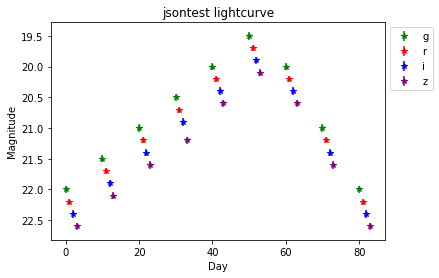

In [7]:
colors = {'g':'green','r':'red','i':'blue','z':'purple'}
tde_table = TDE_raw('jsontest.json')
# Plot the lightcurve from the narrowed points with respect to each filter

for f in ['g', 'r', 'i', 'z']:
    filter_match = tde_table['filter'] == f
    plt.errorbar(tde_table['mjd'][filter_match], tde_table['mag'][filter_match], 
                 yerr=tde_table['magerror'][filter_match], fmt='*', color=colors[f], label = f)
plt.ylim(plt.ylim()[::-1])
plt.title('jsontest lightcurve')
plt.xlabel('Day')
plt.ylabel('Magnitude')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

The next function identifies where the peak is in your input lightcurve data. This is useful for general analysis, but also allows the peak magnitude and time of peak to be manipulated in each filter later on.

In [8]:
def Create_Peak(tde_table):
    peak = {}
    for f in ['g', 'r', 'i', 'z']:
        filter_match = np.where(tde_table['filter'] == f)
        maxmag = np.amin(tde_table['mag'][filter_match])
        row = np.argmin(tde_table['mag'][filter_match])
        maxday = tde_table['mjd'][filter_match][row]
        peak[f] = (maxday, maxmag)
    peak = Table(peak)
    peak[''] = ['peaktime_raw', 'peakmagmag_raw']
    peak = peak['', 'g','r','i','z']
    return peak

In [9]:
peak = Create_Peak(tde_table)
peak

col0,g,r,i,z
str14,float64,float64,float64,float64
peaktime_raw,50.0,51.0,52.0,53.0
peakmagmag_raw,19.5,19.7,19.9,20.1


The following function changes the magnitude and time of the peak for variations of the original lightcurve to be created. This is tested in the final "for" loop.

In [10]:
def Peak_Change(peak, tde_table):
    magdiff = peak['r'][1] - mag
    timediff = peak['r'][0] - day
    tde_table['mag'] = tde_table['mag'] - magdiff
    tde_table['mjd'] = tde_table['mjd'] - timediff
    return tde_table

Below, we refine the survey to list the days only as far as the lightcurve goes. This changes as we change our day for "peaktime" so there is no concern about missing parts of the survey.

In [30]:
def Survey_Refine(opsim, tde_table):
    # Setup empty dictionary for interpolated lightcurve 
    tde_lc = {}
    opsim = opsim[opsim['expMJD'] < tde_table['mjd'].max()]
    opsim = opsim[opsim['expMJD'] > tde_table['mjd'].min()]
    return opsimlist

In [12]:
def Interpolate_LC(tde_table, opsim):
    # Interpolate lightcurve for days of LSST survey
    tde_lc = {}
    for f in ['g', 'r', 'i', 'z']:
        filter_match = np.where(tde_table['filter'] == f)
        tde_lc[f] = np.interp(opsim['expMJD'], tde_table['mjd'][filter_match], tde_table['mag'][filter_match])
    tde_lc = Table(tde_lc)
    tde_lc['mjd'] = opsim['expMJD']
    tde_lc = tde_lc['mjd', 'g', 'r', 'i', 'z']
    return tde_lc

In [13]:
def Survey_Update(opsim, tde_lc):    
    # Add a column to the simulation table to include the lightcurve mags, and fill in mag wrt filter
    # This also only finds the data from the lightcurve data in which the "mjd" matches with the simulation
    # Hence this "resamples" the lightcurve
    opsim['magnitude'] = 0.0
    for row in range(len(opsim)):
        filterName = opsim['filter'][row]
        opsim['magnitude'][row] = tde_lc[filterName][row]
    return opsim

In [14]:
def Find_Error(opsim):
    # Find error based off of 5sigDepth, and add it to the table with magnitudes
    snr = 5*(10**((-0.4)*(opsim['magnitude'] - opsim['fiveSigmaDepth'])))
    tde_err = 2.5/(snr*np.log(10))
    opsim['tde_err'] = tde_err
    return opsim

In [15]:
def Peak_Change_Back(peak, tde_table):
    magdiff = peak['r'][1] - mag
    timediff = peak['r'][0] - day
    tde_table['mag'] = tde_table['mag'] + magdiff
    tde_table['mjd'] = tde_table['mjd'] + timediff
    return tde_table

In [16]:
lowestpeakmag = np.arange(19, 22, 1)
lowestpeaktime = np.arange(38, 43, 1)
colors = {'g':'green','r':'red','i':'blue','z':'purple'}

In [29]:
for coord in range(len(bundle.metricValues)):
    opsim = opsimlist[coord]
    for mag in lowestpeakmag:
        for day in lowestpeaktime:
            tde_table = Peak_Change(peak, tde_table)
            opsim = Survey_Refine(opsim, tde_table)
            tde_lc = Interpolate_LC(tde_table, opsim)
            opsim = Survey_Update(opsim, tde_lc)
            opsim = Find_Error(opsim)
            plt.figure()
            for f in ['g', 'r', 'i', 'z']:
                filter_match = np.where(opsim['filter'] == f)
                plt.errorbar(opsim['expMJD'][filter_match], opsim['magnitude'][filter_match],
                             color = colors[f], fmt = '*', label = f)
            plt.ylim(plt.ylim()[::-1])
            plt.title('PS1-10jh resampled lightcurve, peakmag = %d and peaktime = %d' % (mag, day))
            plt.xlabel('Day')
            plt.ylabel('Magnitude')
            tde_table = Peak_Change_Back(peak, tde_table)

TypeError: list indices must be integers, not str